In [1]:
#%%
import sys, os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import pickle
import json
from util import (
    load_GaMMA_catalog,
    load_scsn,
    load_Ross2019,
    load_Shelly2020,
    load_Liu2020,
    filter_catalog,
    calc_detection_performance,
    calc_time_loc_error,
    plot_loc_error,
    timestamp,
    calc_time_mag_error,
)

sns.set_theme()


In [2]:
#%%
dates =[f"2019-07-{x:02d}" for x in range(4, 11)]
start_datetime = datetime.fromisoformat(dates[0])
end_datetime = datetime.fromisoformat(dates[-1])
hours = range(24)
xmin = 0
xmax = 111.2
ymin = xmin
ymax = xmax

if not os.path.exists("figures"):
    os.makedirs("figures")

In [3]:
t_pred, xyz_pred, mag_pred, catalog_pred = filter_catalog(load_GaMMA_catalog("merged_catalog.csv"), start_datetime, end_datetime, xmin, xmax, ymin, ymax)
t_scsn, xyz_scsn, mag_scsn, catalog_scsn = filter_catalog(load_scsn(), start_datetime, end_datetime, xmin, xmax, ymin, ymax)
t_ross2019, xyz_ross2019, mag_ross2019, catalog_ross2019 = filter_catalog(load_Ross2019(), start_datetime, end_datetime, xmin, xmax, ymin, ymax)
t_liu2020, xyz_liu2020, mag_liu2020, catalog_liu2020 = filter_catalog(load_Liu2020(), start_datetime, end_datetime, xmin, xmax, ymin, ymax)
t_shelly2020, xyz_shelly2020, mag_shelly2020, catalog_shelly2020 = filter_catalog(load_Shelly2020(), start_datetime, end_datetime, xmin, xmax, ymin, ymax)


Filtered catalog 2019-07-04 00:00:00-2019-07-10 00:00:00: 34791 events
Filtered catalog 2019-07-04 00:00:00-2019-07-10 00:00:00: 9873 events
Filtered catalog 2019-07-04 00:00:00-2019-07-10 00:00:00: 29384 events
Filtered catalog 2019-07-04 00:00:00-2019-07-10 00:00:00: 15421 events
Filtered catalog 2019-07-04 00:00:00-2019-07-10 00:00:00: 16778 events


In [4]:

catalog_scsn[ catalog_scsn["time"] > datetime.fromisoformat("2019-07-04T19:10:52")].iloc[:13]["time"]

10537   2019-07-04 19:11:25.420
10538   2019-07-04 19:11:52.840
10539   2019-07-04 19:11:58.470
10540   2019-07-04 19:12:42.070
10541   2019-07-04 19:12:47.180
10542   2019-07-04 19:13:04.540
10543   2019-07-04 19:13:17.100
10544   2019-07-04 19:13:41.110
10545   2019-07-04 19:14:59.490
10546   2019-07-04 19:15:19.590
10547   2019-07-04 19:16:06.320
10548   2019-07-04 19:16:17.580
10549   2019-07-04 19:16:57.400
Name: time, dtype: datetime64[ns]

439    2019-07-04T19:11:25.316
440    2019-07-04T19:11:34.611
441    2019-07-04T19:11:42.028
442    2019-07-04T19:11:52.438
443    2019-07-04T19:11:57.699
444    2019-07-04T19:12:17.677
445    2019-07-04T19:12:21.945
446    2019-07-04T19:12:37.818
447    2019-07-04T19:12:41.528
448    2019-07-04T19:12:50.145
449    2019-07-04T19:12:58.393
450    2019-07-04T19:13:03.907
451    2019-07-04T19:13:16.598
452    2019-07-04T19:13:40.597
453    2019-07-04T19:13:53.690
454    2019-07-04T19:14:01.863
455    2019-07-04T19:14:13.639
456    2019-07-04T19:14:27.853
457    2019-07-04T19:14:59.029
458    2019-07-04T19:15:19.229
459    2019-07-04T19:15:23.884
460    2019-07-04T19:15:46.927
461    2019-07-04T19:16:05.994
462    2019-07-04T19:16:17.594
463    2019-07-04T19:16:36.622
464    2019-07-04T19:16:56.866
Name: time, dtype: object

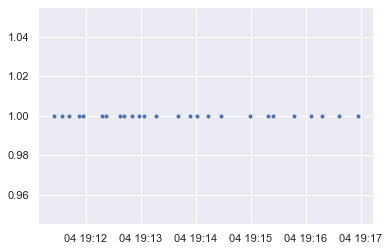

In [5]:
plt.plot(np.array(catalog_pred[ catalog_pred["time"] > "2019-07-04T19:10:52"].iloc[:26]["time"]).astype("datetime64[ms]"), np.ones(26), '.')

catalog_pred[ catalog_pred["time"] > "2019-07-04T19:10:52"].iloc[:26]["time"]

In [6]:
result_label="GMMA"
catalog_label="SCSN"
# catalog_label="IRIS"
catalog_file = "merged_catalog.csv"
picks_file = "merged_picks.csv"

dir_name = "./"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
root_dir = lambda x: os.path.join(dir_name, x)

with open(root_dir("config.json"), "r") as fp:
    config = json.load(fp)
stations = pd.read_csv(root_dir("stations.csv"), delimiter="\t")
# events = pd.read_csv(root_dir("events.csv"), delimiter="\t")
# events["time"] = events["time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f"))
# catalog = pd.read_csv(root_dir(catalog_file), delimiter="\t")
# catalog["time"] = catalog["time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f"))
events = catalog_scsn
catalog = catalog_pred
catalog["covariance"] = catalog["covariance"].apply(lambda x: [float(i) for i  in x.split(",")])

marker_size = 0.1
bins = min(len(catalog["time"])//50 + 10, 50)

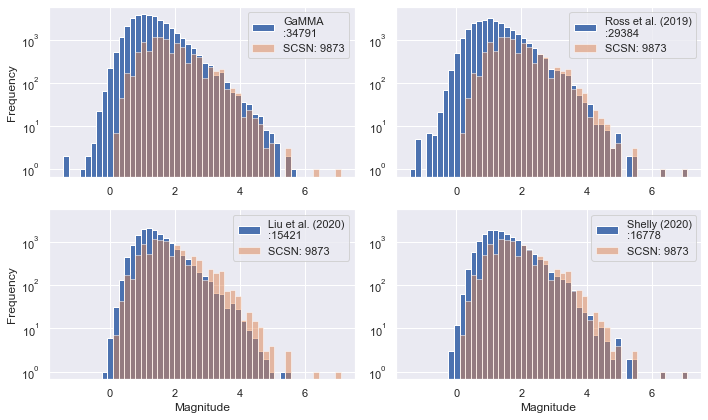

In [7]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.hist(mag_pred, bins=50, range=[np.min([np.min(mag_pred), np.min(mag_scsn)]), np.max([np.max(mag_pred), np.max(mag_scsn)])], label=f"GaMMA\n:{len(mag_pred)}")
plt.hist(mag_scsn, bins=50, range=[np.min([np.min(mag_pred), np.min(mag_scsn)]), np.max([np.max(mag_pred), np.max(mag_scsn)])], alpha=0.5, label=f"SCSN: {len(mag_scsn)}")
plt.gca().set_yscale('log')
ylim = plt.ylim()
plt.legend()
plt.ylabel("Frequency")
plt.subplot(2, 2, 2)
plt.hist(mag_ross2019, bins=50, range=[np.min([np.min(mag_pred), np.min(mag_scsn)]), np.max([np.max(mag_pred), np.max(mag_scsn)])], label=f"Ross et al. (2019)\n:{len(mag_ross2019)}")
plt.hist(mag_scsn, bins=50, range=[np.min([np.min(mag_pred), np.min(mag_scsn)]), np.max([np.max(mag_pred), np.max(mag_scsn)])], alpha=0.5, label=f"SCSN: {len(mag_scsn)}")
plt.gca().set_yscale('log')
plt.ylim(ylim)
plt.legend()
plt.subplot(2, 2, 3)
plt.hist(mag_liu2020, bins=50, range=[np.min([np.min(mag_pred), np.min(mag_scsn)]), np.max([np.max(mag_pred), np.max(mag_scsn)])], label=f"Liu et al. (2020)\n:{len(mag_liu2020)}")
plt.hist(mag_scsn, bins=50, range=[np.min([np.min(mag_pred), np.min(mag_scsn)]), np.max([np.max(mag_pred), np.max(mag_scsn)])], alpha=0.5, label=f"SCSN: {len(mag_scsn)}")
plt.gca().set_yscale('log')
plt.ylim(ylim)
plt.legend()
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.subplot(2, 2, 4)
plt.hist(mag_shelly2020, bins=50, range=[np.min([np.min(mag_pred), np.min(mag_scsn)]), np.max([np.max(mag_pred), np.max(mag_scsn)])], label=f"Shelly (2020)\n:{len(mag_shelly2020)}")
plt.hist(mag_scsn, bins=50, range=[np.min([np.min(mag_pred), np.min(mag_scsn)]), np.max([np.max(mag_pred), np.max(mag_scsn)])], alpha=0.5,  label=f"SCSN: {len(mag_scsn)}")
plt.gca().set_yscale('log')
plt.ylim(ylim)
plt.legend()
plt.xlabel("Magnitude")
plt.tight_layout()
plt.savefig("figures/compare_magnitude.png", bbox_inches="tight", dpi=300)
plt.savefig("figures/compare_magnitude.pdf", bbox_inches="tight")

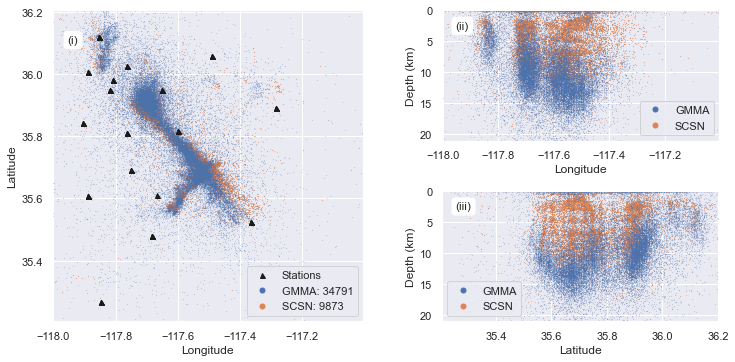

In [8]:
marker_size = 0.5
alpha = 0.2

fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([1.8,1.3]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.92]
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1,1])
fig.add_subplot(grd[:, 0])
plt.scatter(events["longitude"], events["latitude"], s=marker_size, c="C1", linewidths=marker_size, alpha=0.5, rasterized=True)
plt.scatter(catalog["longitude"], catalog["latitude"], s=marker_size, c="C0", linewidths=marker_size, alpha=alpha, rasterized=True)
plt.plot(stations["longitude"], stations["latitude"], 'k^', markersize=5, alpha=1.0, label="Stations")
plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"]))#+np.array([0.2,-0.27]))
plt.ylim(np.array(config["ylim_degree"]))#+np.array([0.2,-0.27]))
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, config["ylim_degree"][0]-10, '.', c="C0", markersize=10, label=f"{result_label}: {len(catalog['time'])}")
plt.plot(config["xlim_degree"][0]-10, config["ylim_degree"][0]-10, '.', c="C1", markersize=10, label=f"{catalog_label}: {len(events['time'])}")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontweight="normal", bbox=box)

fig.add_subplot(grd[0, 1])
plt.scatter(events["longitude"], events["depth(m)"]/1e3, s=marker_size, c="C1", linewidths=marker_size, alpha=0.5, rasterized=True)
plt.scatter(catalog["longitude"], catalog["depth(m)"]/1e3, s=marker_size, c="C0", linewidths=marker_size, alpha=alpha, rasterized=True)
# plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"]))#+np.array([0.2,-0.27]))
plt.ylim([0,21])
# plt.ylim(bottom=0, top=41)
plt.gca().invert_yaxis()
plt.xlabel("Longitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, 31, '.', c="C0", markersize=10, label=f"{result_label}")
plt.plot(31, 31, '.', c="C1", markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontweight="normal", bbox=box)

fig.add_subplot(grd[1, 1])
plt.scatter(events["latitude"], events["depth(m)"]/1e3, s=marker_size, c="C1", linewidths=marker_size, alpha=0.5, rasterized=True)
plt.scatter(catalog["latitude"], catalog["depth(m)"]/1e3, s=marker_size, c="C0", linewidths=marker_size, alpha=alpha, rasterized=True)
# plt.axis("scaled")
plt.xlim(np.array(config["ylim_degree"]))#+np.array([0.2,-0.27]))
plt.ylim([0,21])
# plt.ylim(bottom=0, top=41)
plt.gca().invert_yaxis()
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["ylim_degree"][0]-10, 31, '.', c="C0", markersize=10, label=f"{result_label}")
plt.plot(31, 31, '.', c="C1", markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower left")
plt.tight_layout()
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontweight="normal", bbox=box)
plt.savefig(root_dir("figures/earthquake_location.png"), bbox_inches="tight", dpi=300)
plt.savefig(root_dir("figures/earthquake_location.pdf"), bbox_inches="tight", dpi=300)
plt.show()

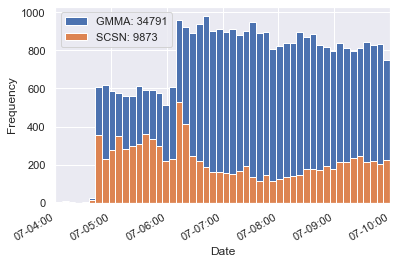

In [9]:
plt.figure()
plt.hist(np.array(catalog["time"]).astype("datetime64[ms]"), range=(config["starttime"], config["endtime"]), bins=bins, label=f"{result_label}: {len(catalog['time'])}")
plt.hist(np.array(events["time"]).astype("datetime64[ms]"), range=(config["starttime"], config["endtime"]), bins=bins, label=f"{catalog_label}: {len(events['time'])}")
plt.ylabel("Frequency")
plt.xlabel("Date")
# plt.yscale("log")
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig(root_dir("figures/earthquake_number.png"), bbox_inches="tight", dpi=300)
plt.savefig(root_dir("figures/earthquake_number.pdf"), bbox_inches="tight")
plt.show()

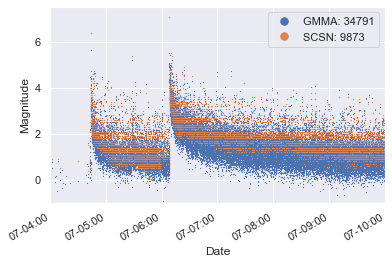

In [10]:
marker_size = 0.5
plt.figure()
plt.scatter(np.array(catalog["time"]).astype("datetime64[ms]"), catalog["magnitude"], s=marker_size, linewidths=marker_size, alpha=1.0, rasterized=True)
plt.scatter(np.array(events["time"]).astype("datetime64[ms]"), events["magnitude"], s=marker_size, linewidths=marker_size, alpha=1.0, rasterized=True)
plt.xlim(config["starttime"], config["endtime"])
# plt.ylim(top=events["magnitude"].max())
ylim = plt.ylim(bottom=-1)
xlim = plt.xlim()
plt.ylabel("Magnitude")
plt.xlabel("Date")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.gca().set_prop_cycle(None)
plt.plot(datetime.fromisoformat(config["starttime"]), -10, '.', markersize=15, alpha=1.0, label=f"{result_label}: {len(catalog['magnitude'])}")
plt.plot(datetime.fromisoformat(config["starttime"]), -10, '.', markersize=15, alpha=1.0, label=f"{catalog_label}: {len(events['magnitude'])}")
plt.legend()
plt.xlim(xlim)
plt.ylim(ylim)
# plt.grid()
plt.savefig(root_dir("figures/earthquake_magnitude_time.png"), bbox_inches="tight", dpi=300)
plt.savefig(root_dir("figures/earthquake_magnitude_time.pdf"), bbox_inches="tight", dpi=300)
plt.show();

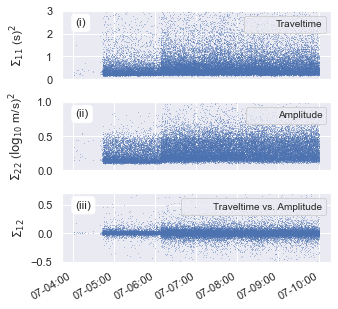

In [11]:
marker_size = 0.2

covariance = np.array(catalog["covariance"].to_list())

fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([0.8,1.1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.90]
plt.subplot(311)
plt.scatter(np.array(catalog["time"]).astype("datetime64[ms]"), covariance[:,0], s=marker_size, linewidths=marker_size, label="Traveltime", rasterized=True)
plt.ylim([0, 3])
plt.ylabel(r"$\Sigma_{11}$ (s)$^2$")
plt.legend(loc="upper right", fontsize="small")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontweight="normal", bbox=box)
plt.subplot(312)
plt.scatter(np.array(catalog["time"]).astype("datetime64[ms]"), covariance[:,1], s=marker_size, linewidths=marker_size, label="Amplitude", rasterized=True)
plt.ylim([0, 1])
plt.ylabel(r"$\Sigma_{22}$ ($\log_{10}$ m/s)$^2$")
plt.legend(loc="upper right", fontsize="small")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontweight="normal", bbox=box)
plt.subplot(313)
plt.scatter(np.array(catalog["time"]).astype("datetime64[ms]"), covariance[:,2], s=marker_size, linewidths=marker_size, label="Traveltime vs. Amplitude", rasterized=True)
plt.ylabel(r"$\Sigma_{12}$")
plt.ylim([-0.5, 0.7])
plt.legend(loc="upper right", fontsize="small")
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontweight="normal", bbox=box)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
# plt.suptitle(r"Covariance Matrix ($\Sigma$) Coefficients")
plt.tight_layout()
plt.gcf().align_labels()
plt.savefig(root_dir("figures/covariance.png"), bbox_inches="tight", dpi=300)
plt.savefig(root_dir("figures/covariance.pdf"), bbox_inches="tight", dpi=300)
plt.show();

In [12]:
#%% plot error distribution
time_threshold = 5
err_time, err_xyz, err_xy, _, _, t = calc_time_loc_error(t_pred, xyz_pred, t_scsn, xyz_scsn, time_threshold)

['2019-07-04 00:00:00', '2019-07-10 00:00:00']


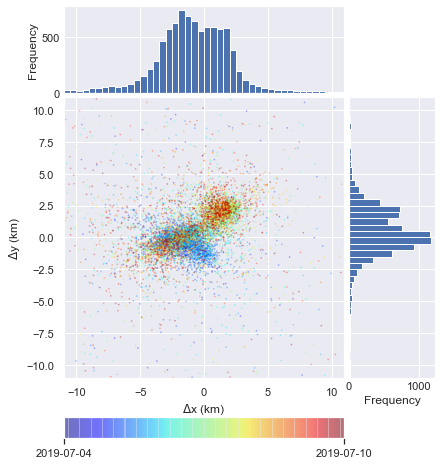

In [13]:
x = err_xyz[:,0]
y = err_xyz[:,1]

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.01

rect_scatter = [left, bottom, width, height]
rect_colorbar = [left, bottom - 0.13 - spacing, width, 0.05]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(6, 6))

ax_scatter = plt.axes(rect_scatter)
ax_colorbar = plt.axes(rect_colorbar)

# ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
sc = ax_scatter.scatter(x, y, s=0.5, c=t, cmap="jet", alpha=0.3, rasterized=True)
ax_scatter.set_xlabel("$\Delta$x (km)")
ax_scatter.set_ylabel("$\Delta$y (km)")

cbar = plt.colorbar(sc, cax=ax_colorbar, orientation="horizontal", ticks=[t[0],  t[-1]])
print([str(start_datetime), str(end_datetime)])
cbar.ax.set_xticklabels([dates[0], dates[-1]]) 

# now determine nice limits by hand:
# binwidth = 0.25
# lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
binwidth = 0.5
lim = 11
ax_scatter.set_xlim((-lim, lim))
ax_scatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histx.set_ylabel("Frequency")
ax_histy.set_xlabel("Frequency")

plt.savefig(f"figures/error-xy-{dates[0]}-{dates[-1]}.png", bbox_inches="tight", dpi=300)
plt.savefig(f"figures/error-xy-{dates[0]}-{dates[-1]}.pdf", bbox_inches="tight", dpi=300)


In [14]:
idx = (np.abs(err_xyz[:,0]) < 10) & (np.abs(err_xyz[:,1]) < 10)
print("Mean", np.mean(err_xyz[idx,0]), np.mean(err_xyz[idx,1]), np.mean(err_xyz[idx,2])/1000)
print("STD", np.std(err_xyz[idx,0]), np.std(err_xyz[idx,1]), np.std(err_xyz[idx,2])/1000)
print("MAE", np.mean(np.abs(err_xyz[idx,0])), np.mean(np.abs(err_xyz[idx,1])), np.mean(np.abs(err_xyz[idx,2]))/1000)

Mean -0.8545617211470791 0.4589304987851462 10.750189993042673
STD 2.6077657942024555 2.111165297311899 3.803372538549697
MAE 2.134975255515023 1.5335998953437908 10.750502658627084


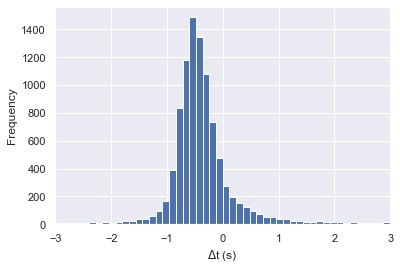

In [15]:
plt.figure()
plt.hist(err_time, range=(-3,3), bins=50)
plt.xlim([-3, 3])
plt.ylabel("Frequency")
plt.xlabel("$\Delta$t (s)")
plt.savefig(f"figures/error-t-{dates[0]}-{dates[-1]}.png", bbox_inches="tight", dpi=300)
plt.savefig(f"figures/error-t-{dates[0]}-{dates[-1]}.pdf", bbox_inches="tight", dpi=300)


In [16]:
idx = (np.abs(err_time) < 3)
print("Mean", np.mean(err_time))
print("STD", np.std(err_time))
print("MAE", np.mean(np.abs(err_time)))

Mean -0.358589068203893
STD 0.8025796444533159
MAE 0.6266436231271681


In [17]:
err_time, err_mag, t, mag = calc_time_mag_error(t_pred, mag_pred, t_scsn, mag_scsn, time_threshold)

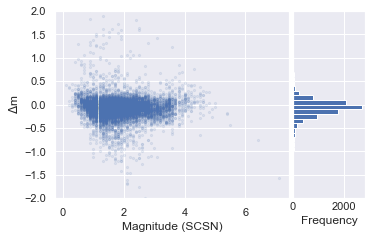

In [18]:
x = mag
y = err_mag

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.01

rect_scatter = [left, bottom, width, height]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(5, 4))

ax_scatter = plt.axes(rect_scatter)
# ax_colorbar = plt.axes(rect_colorbar)

# ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
sc = ax_scatter.scatter(x, y, s=5, alpha=0.1, rasterized=True)
ax_scatter.set_xlabel("Magnitude (SCSN)")
ax_scatter.set_ylabel("$\Delta$m")

# now determine nice limits by hand:
binwidth = 0.1
lim = 2
ax_scatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histy.hist(y, bins=bins, orientation='horizontal')

ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_xlabel("Frequency")

plt.savefig(f"figures/error-mag-{dates[0]}-{dates[-1]}.png", bbox_inches="tight", dpi=300)
plt.savefig(f"figures/error-mag-{dates[0]}-{dates[-1]}.pdf", bbox_inches="tight", dpi=300)


In [19]:
idx = (np.abs(err_mag) < 2)
print("Mean", np.mean(err_mag))
print("STD", np.std(err_mag))
print("MAE", np.mean(np.abs(err_mag)))

Mean -0.0640668401874024
STD 0.23484066814711507
MAE 0.15373472149921913


In [20]:
# %% 
# compare with other catalog
time_threshold = 5
fp = open(f"performance-{dates[0]}-{dates[-1]}.txt", "w")
recall, precision, f1 = calc_detection_performance(t_pred, t_scsn, time_threshold)
print(f"Pred vs. SCSN : recall={recall:.3f}, precision={precision:.3f}, f1={f1:.3f}")
fp.write(f"Pred vs. SCSN : {len(t_pred)}, {len(t_scsn)}\n")
fp.write(f"Pred vs. SCSN : recall={recall:.3f}, precision={precision:.3f}, f1={f1:.3f}\n")
recall, precision, f1 = calc_detection_performance(t_pred, t_shelly2020, time_threshold)
print(f"Pred vs. Shelly (2020) : recall={recall:.3f}, precision={precision:.3f}, f1={f1:.3f}")
fp.write(f"Pred vs. Shelly (2020) : {len(t_pred)}, {len(t_shelly2020)}\n")
fp.write(f"Pred vs. Shelly (2020) : recall={recall:.3f}, precision={precision:.3f}, f1={f1:.3f}\n")
recall, precision, f1 = calc_detection_performance(t_pred, t_liu2020, time_threshold)
print(f"Pred vs. Ming (2020) : recall={recall:.3f}, precision={precision:.3f}, f1={f1:.3f}")
fp.write(f"Pred vs. Ming (2020) : {len(t_pred)}, {len(t_liu2020)}\n")
fp.write(f"Pred vs. Ming (2020) : recall={recall:.3f}, precision={precision:.3f}, f1={f1:.3f}\n")
recall, precision, f1 = calc_detection_performance(t_pred, t_ross2019, time_threshold)
print(f"Pred vs. Zachary (2019) : recall={recall:.3f}, precision={precision:.3f}, f1={f1:.3f}")
fp.write(f"Pred vs. Zachary (2019) : {len(t_pred)}, {len(t_ross2019)}\n")
fp.write(f"Pred vs. Zachary (2019) : recall={recall:.3f}, precision={precision:.3f}, f1={f1:.3f}\n")
fp.write(f"=======================================================\n")

Pred vs. SCSN : recall=0.973, precision=0.336, f1=0.499
Pred vs. Shelly (2020) : recall=0.955, precision=0.552, f1=0.699
Pred vs. Ming (2020) : recall=0.987, precision=0.576, f1=0.727
Pred vs. Zachary (2019) : recall=0.737, precision=0.765, f1=0.751


56

In [21]:
picks = pd.read_csv("merged_picks.csv", sep="\t")

In [22]:
print(f"P-picks: {len(picks[(picks['type']=='p')])}")
print(f"S-picks: {len(picks[(picks['type']=='s')])}")
print(f"Associated P-picks: {len(picks[(picks['type']=='p') & (picks['event_idx']!=-1)])}")
print(f"Associated S-picks: {len(picks[(picks['type']=='s') & (picks['event_idx']!=-1)])}")
print(f"Unassociated P-picks: {len(picks[(picks['type']=='p')]) - len(picks[(picks['type']=='p') & (picks['event_idx']!=-1)])}")
print(f"Unassociated S-picks: {len(picks[(picks['type']=='s')]) - len(picks[(picks['type']=='s') & (picks['event_idx']!=-1)])}")

P-picks: 651994
S-picks: 686291
Associated P-picks: 598218
Associated S-picks: 633010
Unassociated P-picks: 53776
Unassociated S-picks: 53281


In [23]:
(picks["event_idx"]!=-1)

0          True
1          True
2          True
3          True
4          True
           ... 
1338280    True
1338281    True
1338282    True
1338283    True
1338284    True
Name: event_idx, Length: 1338285, dtype: bool

In [24]:
len(picks[(picks["type"]=="s") & (picks["event_idx"]!=-1)])

633010

In [25]:
len(picks[picks["event_idx"]==-1])

107057

In [26]:
picks[picks["event_idx"]==-1]

,id,timestamp,type,prob,amp,prob_gmma,event_idx,file_index
10,CI.DTP..HH,2019-07-04T00:00:45.520000,s,0.586722,4.495422e-07,-1.0,-1,0
11,CI.JRC2..HN,2019-07-04T00:01:03.420000,s,0.392641,8.206393e-07,-1.0,-1,0
12,CI.CCC..BH,2019-07-04T00:04:39.390000,s,0.392486,2.734438e-06,-1.0,-1,0
13,CI.CCC..BH,2019-07-04T00:06:44.540000,s,0.874934,2.112931e-06,-1.0,-1,0
14,CI.CCC..BH,2019-07-04T00:06:53.750000,s,0.523007,1.015641e-06,-1.0,-1,0
...,...,...,...,...,...,...,...,...
1338213,CI.CLC..BH,2019-07-09T23:59:25.284000,s,0.736826,2.751237e-07,-1.0,-1,23
1338214,CI.CLC..HH,2019-07-09T23:59:32.614000,p,0.319237,4.155995e-07,-1.0,-1,23
1338215,CI.CLC..BH,2019-07-09T23:59:35.024000,s,0.329072,3.295172e-07,-1.0,-1,23
1338216,CI.CLC..HH,2019-07-09T23:59:35.024000,s,0.879812,4.155995e-07,-1.0,-1,23


In [27]:
num = 0
for i in range(24):
    tmp = picks[picks["file_index"]==i]["event_idx"].max()
    num += tmp
    print(i, tmp)
print("total:", num)

0 1256
1 1321
2 1276
3 1403
4 1438
5 1432
6 1425
7 1382
8 1455
9 1368
10 1425
11 1440
12 1467
13 1459
14 1475
15 1410
16 1483
17 1564
18 1637
19 1669
20 1620
21 1538
22 1597
23 1474
total: 35014


In [28]:
np.max(picks[picks["file_index"]==0]["event_idx"])

1256

In [29]:
num

35014